<a href="https://colab.research.google.com/github/agarr3/vajra-new-2/blob/main/AE_HYBRID_INDIAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import torch
# Neural networks can be constructed using the torch.nn package.
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

import IPython.display as ipd

import random

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#settings
batch_size = 64
validation_split = .3
shuffle_dataset = True
random_seed= 42
reduction_loss = "mean"
if reduction_loss == "mean":
  criterion = nn.MSELoss(reduction="mean")
elif reduction_loss == "sum":
  criterion = nn.MSELoss(reduction="sum")
n_epochs = 30
print_every = 1

BASE_PATH = "/content/gdrive/My Drive/vajra/AE_HYBRID_INDIAN/"

input_bins = 48
seq_len=200
AE_encoded_dim = 64

class_level_loss_mode = "test"

print(device)

cuda:0


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
DATA_BASE_PATH = "/content/gdrive/My Drive/vajra/songs-vajra-data/MEL/48Bins"
DATA_SONG_DIR = "Chunked"
DATA_IMG_DIR = "Chunked"

files = []


indian_files = []
for r,d, fileList in os.walk(os.path.join(DATA_BASE_PATH, DATA_SONG_DIR, "Indian_numpy")):
  for file in fileList:
    if(True):
      indian_files.append([file,file, "Indian_numpy"])
    else:
      print(file)

files = indian_files
dataDF = pd.DataFrame(files, columns=['Images','songs','labels'])
dataDF.head()

,Images,songs,labels
0,indianNizhalinaiNijamum_mel_0.npy,indianNizhalinaiNijamum_mel_0.npy,Indian_numpy
1,indianNizhalinaiNijamum_mel_1.npy,indianNizhalinaiNijamum_mel_1.npy,Indian_numpy
2,indianOhOh_mel_0.npy,indianOhOh_mel_0.npy,Indian_numpy
3,indianOhOh_mel_1.npy,indianOhOh_mel_1.npy,Indian_numpy
4,indianOnnavittaYaarumYenakilla_mel_0.npy,indianOnnavittaYaarumYenakilla_mel_0.npy,Indian_numpy


In [5]:
dataDF.groupby("labels").count()

,Images,songs
labels,,
Indian_numpy,4016,4016


/content/gdrive/My Drive/vajra/songs-vajra-data/MEL/48Bins/Chunked/Indian_numpy/indianBapuZimidar_mel_0.npy
57.60487


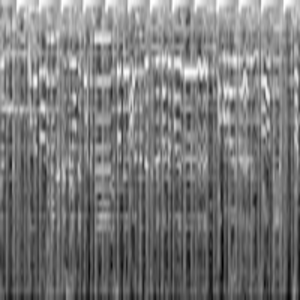

In [6]:
test_idx = random. randint(0,1000)
test_img_path = os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, dataDF.loc[test_idx, 'labels'], dataDF.loc[test_idx, 'Images'])
print(test_img_path)

numpy_arr = np.load(test_img_path)

array = numpy_arr*-1
print(array.max())
array *= (255.0/array.max())
array = 255 - array

test_image = Image.fromarray(array)
test_image = test_image.convert('L')
test_image = test_image.resize((300,300))
test_image



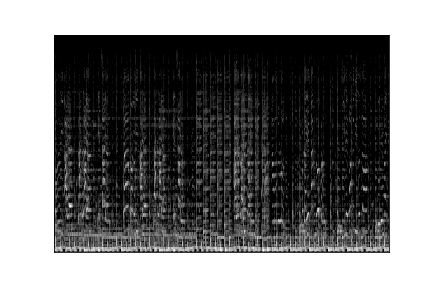

In [7]:
test_img_path = '/content/gdrive/My Drive/Kaggle/GTZAN/Data/images_original/reggae/reggae00016.png'
test_image = Image.open(test_img_path)
test_image = test_image.convert('RGB').convert('L')
test_image

In [8]:
lb = LabelEncoder()
dataDF['encoded_labels'] = lb.fit_transform(dataDF['labels'])
dataDF.head()

,Images,songs,labels,encoded_labels
0,indianNizhalinaiNijamum_mel_0.npy,indianNizhalinaiNijamum_mel_0.npy,Indian_numpy,0
1,indianNizhalinaiNijamum_mel_1.npy,indianNizhalinaiNijamum_mel_1.npy,Indian_numpy,0
2,indianOhOh_mel_0.npy,indianOhOh_mel_0.npy,Indian_numpy,0
3,indianOhOh_mel_1.npy,indianOhOh_mel_1.npy,Indian_numpy,0
4,indianOnnavittaYaarumYenakilla_mel_0.npy,indianOnnavittaYaarumYenakilla_mel_0.npy,Indian_numpy,0


In [9]:
classes = ('Indian_numpy', 'Western_numpy')
dataDF.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,4016,4016


In [11]:
from sklearn.model_selection import train_test_split

dataDF = dataDF.sample(frac=1)
df_train, df_test = train_test_split(dataDF, test_size=validation_split, stratify=dataDF[["labels"]], random_state=9)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


In [12]:
df_train.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,2811,2811


In [13]:
df_test.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,1205,1205


In [14]:
indian_dataDF.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,1205,1205


In [15]:
transform_normal = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose(
    [transforms.ToTensor()])

In [16]:
class MEL_Dataset(Dataset):
    def __init__(self, img_data,img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_path,self.img_data.loc[index, 'labels'],
                                self.img_data.loc[index, 'Images'])
        image = np.load(img_name)
        data = torch.tensor(image[:,:seq_len], dtype=torch.float)
        data = data.permute(1, 0)
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        fileName = self.img_data.loc[index, 'Images']
        return data, label, fileName



In [17]:
train_dataset = MEL_Dataset(df_train,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)
test_dataset = MEL_Dataset(df_test,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)

In [18]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [25]:
indian_dataset = MEL_Dataset(indian_dataDF,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)
indian_loader = torch.utils.data.DataLoader(indian_dataset, batch_size=batch_size)

In [26]:
def mel_display(S_DB):
    S_DB = S_DB.numpy()
    array = S_DB*-1
    array *= (255.0/array.max())
    #array = 255 - array
    array = np.transpose(array, (2, 1, 0))
    return array.squeeze()

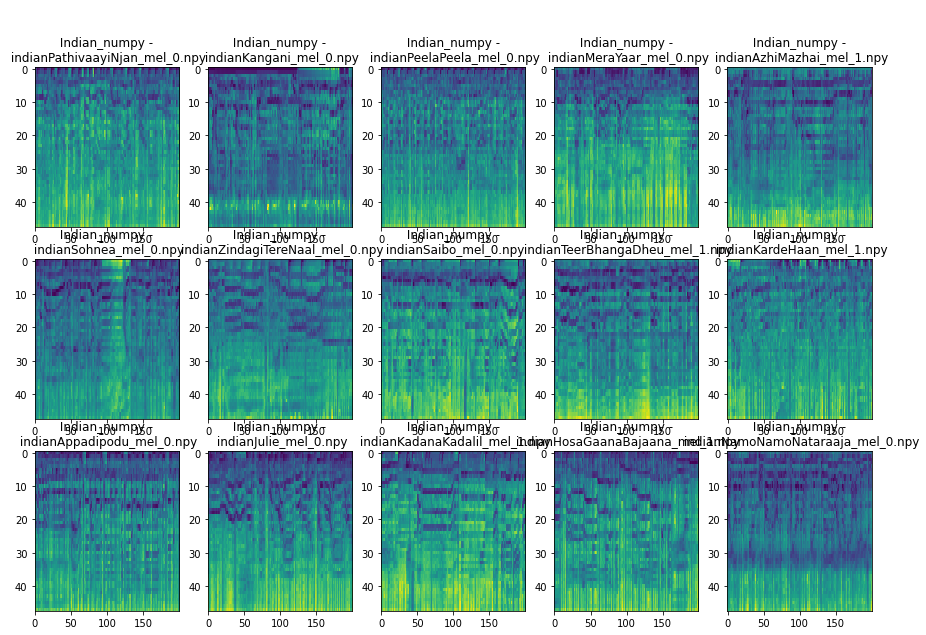

In [27]:
# get some random training images
dataiter = iter(trainloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label, fileName = images[i], labels[i], fileNames[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"\n \n {arthopod_types[label.item()]} - \n {fileName}") # add label

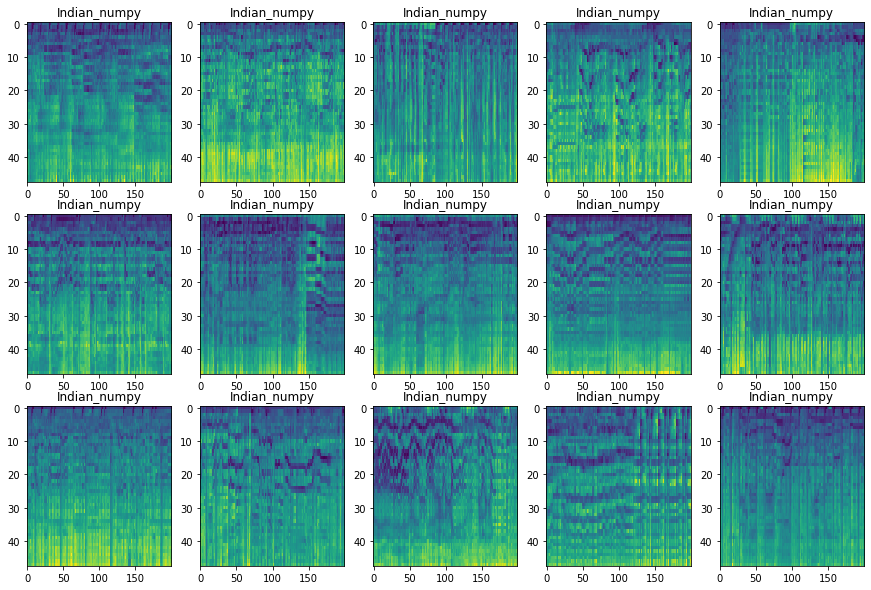

In [28]:
# get some random training images
dataiter = iter(testloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

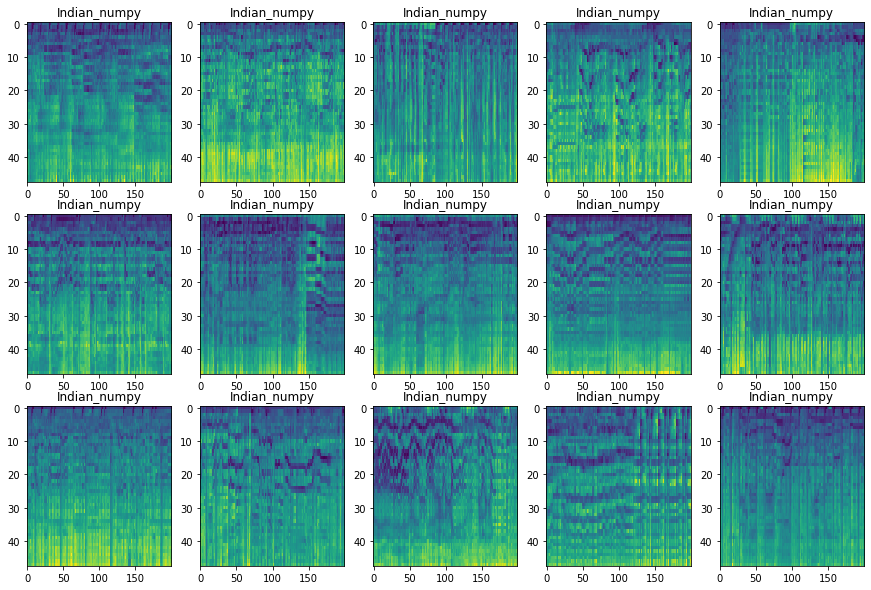

In [29]:
# get some random training images
dataiter = iter(indian_loader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

In [30]:
class Encoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64, kernel_size=[4,3,2], stride=[1,1,1]):
    super(Encoder, self).__init__()
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim


    self.conv = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[0],stride=stride[0], groups=seq_len)
    conv_op_dim = int(((n_features - kernel_size[0])/ stride[0]) + 1)

    self.conv_1 = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[1],stride=stride[1], groups=seq_len)
    conv_op_dim1 = int(((conv_op_dim - kernel_size[1])/ stride[1]) + 1)

    self.conv_2 = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[2],stride=stride[2], groups=seq_len)
    conv_op_dim2 = int(((conv_op_dim1 - kernel_size[2])/ stride[2]) + 1)

    self.rnn1 = nn.LSTM(
      input_size=conv_op_dim2,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
  def forward(self, x):
    x = self.conv(x)
    x = self.conv_1(x)
    x = self.conv_2(x)
    lstm_l1_op, (_, _) = self.rnn1(x)
    lstm_l2_op, (hidden_n, _) = self.rnn2(lstm_l1_op)
    return lstm_l2_op, lstm_l1_op

class Decoder(torch.nn.Module):
  def __init__(self, seq_len, embedding_dim=64, n_features=26):
    super(Decoder, self).__init__()
    self.seq_len, self.embedding_dim = seq_len, embedding_dim
    self.hidden_dim, self.n_features = 2 * embedding_dim, n_features
    self.rnn1 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.output_layer = nn.Linear(self.hidden_dim * self.seq_len, n_features * self.seq_len)
  def forward(self, x):
    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.contiguous()
    x = x.view(x.shape[0], -1)
    x = self.output_layer(x)
    return x.reshape(x.shape[0],self.seq_len, self.n_features)

class RecurrentAutoencoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64, device='cpu'):
    super(RecurrentAutoencoder, self).__init__()
    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
  def forward(self, x):
    x, l1_op = self.encoder(x)
    x = self.decoder(x)
    return x

net = RecurrentAutoencoder(seq_len, input_bins, AE_encoded_dim, device=device)
net.to(device)


RecurrentAutoencoder(
  (encoder): Encoder(
    (conv): Conv1d(200, 200, kernel_size=(4,), stride=(1,), groups=200)
    (conv_1): Conv1d(200, 200, kernel_size=(3,), stride=(1,), groups=200)
    (conv_2): Conv1d(200, 200, kernel_size=(2,), stride=(1,), groups=200)
    (rnn1): LSTM(42, 128, batch_first=True)
    (rnn2): LSTM(128, 64, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(64, 64, batch_first=True)
    (rnn2): LSTM(64, 128, batch_first=True)
    (output_layer): Linear(in_features=25600, out_features=9600, bias=True)
  )
)

In [31]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [32]:
import matplotlib.pyplot as plt
import numpy as np

def visualize(train_loss_graph, test_loss_graph):
  x = range(len(train_loss_graph))
      
  # plot lines
  plt.plot(x, train_loss_graph, label = "Training Loss")
  plt.plot(x, test_loss_graph, label = "Test Loss")
  
  plt.legend()
  plt.show()


def visualize_class_loss(in_loss_graph, we_loss_graph):
  x = range(len(in_loss_graph))
      
  # plot lines
  plt.plot(x, in_loss_graph, label = "Indian Loss")
  plt.plot(x, we_loss_graph, label = "Western Loss")
  
  plt.legend()
  plt.show()


[1,     1] loss: 1192.131
[1,     2] loss: 1198.089
[1,     3] loss: 1055.655
[1,     4] loss: 978.025
[1,     5] loss: 912.367
[1,     6] loss: 745.447
[1,     7] loss: 548.726
[1,     8] loss: 278.323
[1,     9] loss: 141.338
[1,    10] loss: 476.628
[1,    11] loss: 252.560
[1,    12] loss: 104.446
[1,    13] loss: 88.178
[1,    14] loss: 118.043
[1,    15] loss: 139.186
[1,    16] loss: 187.121
[1,    17] loss: 159.025
[1,    18] loss: 172.194
[1,    19] loss: 156.488
[1,    20] loss: 127.483
[1,    21] loss: 96.108
[1,    22] loss: 86.473
[1,    23] loss: 95.790
[1,    24] loss: 105.469
[1,    25] loss: 114.991
[1,    26] loss: 111.483
[1,    27] loss: 123.600
[1,    28] loss: 103.096
[1,    29] loss: 95.253
[1,    30] loss: 82.340
[1,    31] loss: 75.141
[1,    32] loss: 75.293
[1,    33] loss: 97.085
[1,    34] loss: 87.348
[1,    35] loss: 86.037
[1,    36] loss: 86.455
[1,    37] loss: 85.094
[1,    38] loss: 79.727
[1,    39] loss: 78.006
[1,    40] loss: 72.056
[1,    41] lo

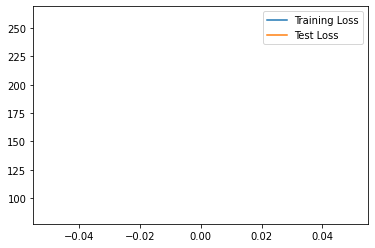

[2,     1] loss: 89.678
[2,     2] loss: 80.761
[2,     3] loss: 75.765
[2,     4] loss: 79.341
[2,     5] loss: 76.662
[2,     6] loss: 74.092
[2,     7] loss: 78.885
[2,     8] loss: 70.360
[2,     9] loss: 78.874
[2,    10] loss: 67.988
[2,    11] loss: 82.535
[2,    12] loss: 72.824
[2,    13] loss: 75.247
[2,    14] loss: 74.151
[2,    15] loss: 69.361
[2,    16] loss: 72.482
[2,    17] loss: 68.001
[2,    18] loss: 75.191
[2,    19] loss: 73.224
[2,    20] loss: 79.342
[2,    21] loss: 72.488
[2,    22] loss: 69.593
[2,    23] loss: 76.709
[2,    24] loss: 73.885
[2,    25] loss: 77.750
[2,    26] loss: 77.840
[2,    27] loss: 89.076
[2,    28] loss: 80.135
[2,    29] loss: 78.723
[2,    30] loss: 78.773
[2,    31] loss: 72.926
[2,    32] loss: 73.505
[2,    33] loss: 86.369
[2,    34] loss: 78.779
[2,    35] loss: 75.923
[2,    36] loss: 75.873
[2,    37] loss: 75.862
[2,    38] loss: 73.505
[2,    39] loss: 74.335
[2,    40] loss: 68.600
[2,    41] loss: 77.816
[2,    42] loss:

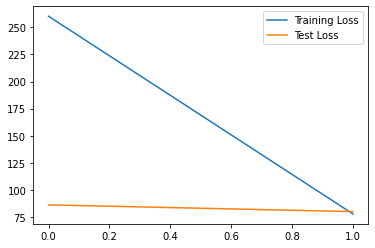

[3,     1] loss: 82.020
[3,     2] loss: 76.575
[3,     3] loss: 70.520
[3,     4] loss: 75.127
[3,     5] loss: 75.194
[3,     6] loss: 72.331
[3,     7] loss: 76.482
[3,     8] loss: 68.542
[3,     9] loss: 76.002
[3,    10] loss: 66.885
[3,    11] loss: 78.785
[3,    12] loss: 71.703
[3,    13] loss: 73.812
[3,    14] loss: 72.571
[3,    15] loss: 67.504
[3,    16] loss: 72.090
[3,    17] loss: 65.552
[3,    18] loss: 73.310
[3,    19] loss: 72.008
[3,    20] loss: 76.796
[3,    21] loss: 70.901
[3,    22] loss: 68.520
[3,    23] loss: 75.507
[3,    24] loss: 72.558
[3,    25] loss: 76.141
[3,    26] loss: 76.935
[3,    27] loss: 86.769
[3,    28] loss: 78.075
[3,    29] loss: 76.794
[3,    30] loss: 76.068
[3,    31] loss: 70.937
[3,    32] loss: 70.710
[3,    33] loss: 83.036
[3,    34] loss: 75.215
[3,    35] loss: 73.920
[3,    36] loss: 73.250
[3,    37] loss: 74.715
[3,    38] loss: 71.877
[3,    39] loss: 70.949
[3,    40] loss: 65.818
[3,    41] loss: 75.131
[3,    42] loss:

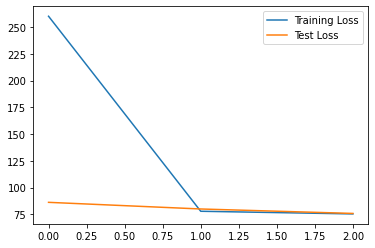

[4,     1] loss: 78.549
[4,     2] loss: 72.384
[4,     3] loss: 68.168
[4,     4] loss: 70.524
[4,     5] loss: 72.420
[4,     6] loss: 68.502
[4,     7] loss: 70.042
[4,     8] loss: 64.566
[4,     9] loss: 70.154
[4,    10] loss: 62.919
[4,    11] loss: 70.318
[4,    12] loss: 64.511
[4,    13] loss: 65.646
[4,    14] loss: 66.731
[4,    15] loss: 63.641
[4,    16] loss: 63.117
[4,    17] loss: 58.519
[4,    18] loss: 64.375
[4,    19] loss: 63.801
[4,    20] loss: 64.339
[4,    21] loss: 60.180
[4,    22] loss: 62.026
[4,    23] loss: 66.207
[4,    24] loss: 63.220
[4,    25] loss: 65.418
[4,    26] loss: 67.877
[4,    27] loss: 74.042
[4,    28] loss: 68.877
[4,    29] loss: 65.254
[4,    30] loss: 62.805
[4,    31] loss: 61.474
[4,    32] loss: 59.161
[4,    33] loss: 66.700
[4,    34] loss: 59.610
[4,    35] loss: 64.608
[4,    36] loss: 62.756
[4,    37] loss: 68.077
[4,    38] loss: 66.422
[4,    39] loss: 60.842
[4,    40] loss: 59.130
[4,    41] loss: 67.438
[4,    42] loss:

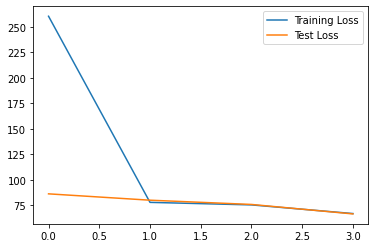

[5,     1] loss: 69.980
[5,     2] loss: 63.003
[5,     3] loss: 59.945
[5,     4] loss: 62.791
[5,     5] loss: 64.750
[5,     6] loss: 60.839
[5,     7] loss: 60.581
[5,     8] loss: 59.127
[5,     9] loss: 61.290
[5,    10] loss: 58.066
[5,    11] loss: 60.459
[5,    12] loss: 59.838
[5,    13] loss: 59.385
[5,    14] loss: 62.679
[5,    15] loss: 59.812
[5,    16] loss: 59.148
[5,    17] loss: 56.455
[5,    18] loss: 61.713
[5,    19] loss: 60.828
[5,    20] loss: 62.018
[5,    21] loss: 57.938
[5,    22] loss: 59.648
[5,    23] loss: 64.426
[5,    24] loss: 62.158
[5,    25] loss: 64.206
[5,    26] loss: 66.339
[5,    27] loss: 71.458
[5,    28] loss: 65.088
[5,    29] loss: 60.856
[5,    30] loss: 61.336
[5,    31] loss: 60.248
[5,    32] loss: 57.893
[5,    33] loss: 65.754
[5,    34] loss: 58.141
[5,    35] loss: 63.877
[5,    36] loss: 61.079
[5,    37] loss: 67.568
[5,    38] loss: 65.630
[5,    39] loss: 60.348
[5,    40] loss: 58.601
[5,    41] loss: 66.745
[5,    42] loss:

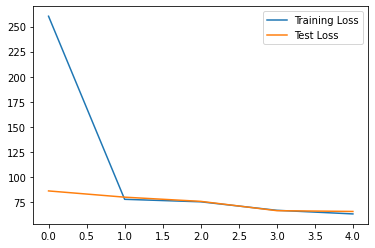

[6,     1] loss: 69.043
[6,     2] loss: 62.847
[6,     3] loss: 59.425
[6,     4] loss: 62.458
[6,     5] loss: 64.565
[6,     6] loss: 60.320
[6,     7] loss: 60.338
[6,     8] loss: 58.417
[6,     9] loss: 60.924
[6,    10] loss: 57.482
[6,    11] loss: 59.406
[6,    12] loss: 59.692
[6,    13] loss: 59.059
[6,    14] loss: 62.396
[6,    15] loss: 59.877
[6,    16] loss: 58.645
[6,    17] loss: 56.567
[6,    18] loss: 61.901
[6,    19] loss: 60.204
[6,    20] loss: 62.042
[6,    21] loss: 57.972
[6,    22] loss: 59.440
[6,    23] loss: 64.385
[6,    24] loss: 62.083
[6,    25] loss: 63.975
[6,    26] loss: 66.088
[6,    27] loss: 71.124
[6,    28] loss: 64.966
[6,    29] loss: 60.839
[6,    30] loss: 61.011
[6,    31] loss: 60.322
[6,    32] loss: 57.861
[6,    33] loss: 65.452
[6,    34] loss: 58.403
[6,    35] loss: 63.672
[6,    36] loss: 60.866
[6,    37] loss: 67.693
[6,    38] loss: 65.353
[6,    39] loss: 60.191
[6,    40] loss: 58.588
[6,    41] loss: 66.331
[6,    42] loss:

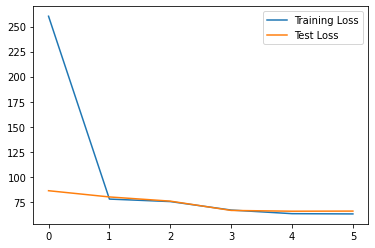

[7,     1] loss: 69.252
[7,     2] loss: 62.724
[7,     3] loss: 59.346
[7,     4] loss: 62.399
[7,     5] loss: 64.312
[7,     6] loss: 60.238
[7,     7] loss: 60.135
[7,     8] loss: 58.413
[7,     9] loss: 60.800
[7,    10] loss: 57.368
[7,    11] loss: 59.409
[7,    12] loss: 59.647
[7,    13] loss: 58.873
[7,    14] loss: 62.496
[7,    15] loss: 59.611
[7,    16] loss: 58.775
[7,    17] loss: 56.690
[7,    18] loss: 61.446
[7,    19] loss: 60.367
[7,    20] loss: 62.061
[7,    21] loss: 57.661
[7,    22] loss: 59.583
[7,    23] loss: 64.251
[7,    24] loss: 62.013
[7,    25] loss: 63.995
[7,    26] loss: 65.875
[7,    27] loss: 70.999
[7,    28] loss: 64.857
[7,    29] loss: 60.479
[7,    30] loss: 60.830
[7,    31] loss: 60.118
[7,    32] loss: 57.394
[7,    33] loss: 65.216
[7,    34] loss: 57.866
[7,    35] loss: 63.416
[7,    36] loss: 60.736
[7,    37] loss: 67.205
[7,    38] loss: 65.123
[7,    39] loss: 59.937
[7,    40] loss: 58.085
[7,    41] loss: 66.091
[7,    42] loss:

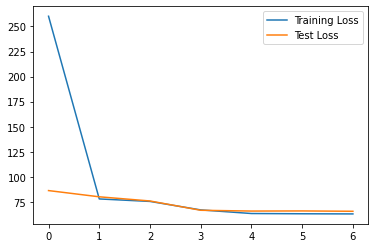

[8,     1] loss: 68.993
[8,     2] loss: 62.536
[8,     3] loss: 59.226
[8,     4] loss: 62.003
[8,     5] loss: 64.185
[8,     6] loss: 59.999
[8,     7] loss: 59.901
[8,     8] loss: 58.201
[8,     9] loss: 60.553
[8,    10] loss: 57.213
[8,    11] loss: 59.038
[8,    12] loss: 59.501
[8,    13] loss: 58.621
[8,    14] loss: 62.235
[8,    15] loss: 59.426
[8,    16] loss: 58.516
[8,    17] loss: 56.386
[8,    18] loss: 61.379
[8,    19] loss: 59.980
[8,    20] loss: 61.817
[8,    21] loss: 57.636
[8,    22] loss: 59.239
[8,    23] loss: 64.219
[8,    24] loss: 61.892
[8,    25] loss: 63.716
[8,    26] loss: 65.804
[8,    27] loss: 70.555
[8,    28] loss: 64.810
[8,    29] loss: 60.379
[8,    30] loss: 60.608
[8,    31] loss: 60.236
[8,    32] loss: 57.284
[8,    33] loss: 64.987
[8,    34] loss: 57.960
[8,    35] loss: 63.345
[8,    36] loss: 60.660
[8,    37] loss: 67.109
[8,    38] loss: 64.922
[8,    39] loss: 59.755
[8,    40] loss: 57.887
[8,    41] loss: 65.906
[8,    42] loss:

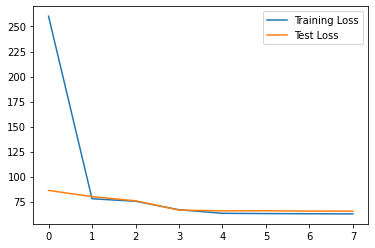

[9,     1] loss: 68.972
[9,     2] loss: 62.473
[9,     3] loss: 59.101
[9,     4] loss: 61.762
[9,     5] loss: 64.049
[9,     6] loss: 59.809
[9,     7] loss: 59.621
[9,     8] loss: 57.994
[9,     9] loss: 60.332
[9,    10] loss: 56.961
[9,    11] loss: 58.746
[9,    12] loss: 59.430
[9,    13] loss: 58.331
[9,    14] loss: 62.087
[9,    15] loss: 59.251
[9,    16] loss: 58.288
[9,    17] loss: 56.237
[9,    18] loss: 61.251
[9,    19] loss: 59.752
[9,    20] loss: 61.626
[9,    21] loss: 57.554
[9,    22] loss: 59.027
[9,    23] loss: 64.100
[9,    24] loss: 61.810
[9,    25] loss: 63.407
[9,    26] loss: 65.601
[9,    27] loss: 70.148
[9,    28] loss: 64.695
[9,    29] loss: 60.193
[9,    30] loss: 60.377
[9,    31] loss: 60.211
[9,    32] loss: 57.020
[9,    33] loss: 64.644
[9,    34] loss: 57.829
[9,    35] loss: 63.177
[9,    36] loss: 60.515
[9,    37] loss: 66.781
[9,    38] loss: 64.604
[9,    39] loss: 59.486
[9,    40] loss: 57.495
[9,    41] loss: 65.633
[9,    42] loss:

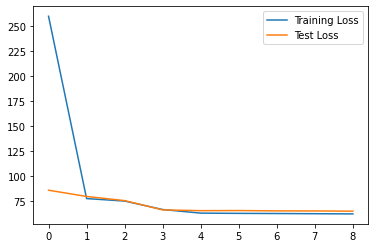

[10,     1] loss: 68.786
[10,     2] loss: 62.262
[10,     3] loss: 58.921
[10,     4] loss: 61.320
[10,     5] loss: 63.818
[10,     6] loss: 59.552
[10,     7] loss: 59.253
[10,     8] loss: 57.749
[10,     9] loss: 60.000
[10,    10] loss: 56.666
[10,    11] loss: 58.385
[10,    12] loss: 59.227
[10,    13] loss: 57.939
[10,    14] loss: 61.822
[10,    15] loss: 58.874
[10,    16] loss: 58.037
[10,    17] loss: 55.969
[10,    18] loss: 60.906
[10,    19] loss: 59.515
[10,    20] loss: 61.353
[10,    21] loss: 57.338
[10,    22] loss: 58.772
[10,    23] loss: 63.845
[10,    24] loss: 61.647
[10,    25] loss: 62.901
[10,    26] loss: 65.153
[10,    27] loss: 69.528
[10,    28] loss: 64.559
[10,    29] loss: 59.882
[10,    30] loss: 60.087
[10,    31] loss: 60.068
[10,    32] loss: 56.538
[10,    33] loss: 64.049
[10,    34] loss: 57.567
[10,    35] loss: 62.830
[10,    36] loss: 60.258
[10,    37] loss: 66.113
[10,    38] loss: 64.029
[10,    39] loss: 59.063
[10,    40] loss: 56.847


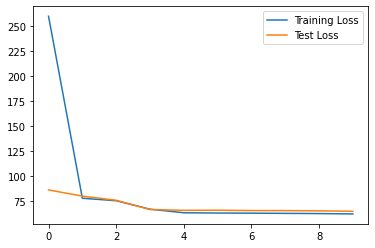

[11,     1] loss: 68.302
[11,     2] loss: 61.826
[11,     3] loss: 58.581
[11,     4] loss: 60.407
[11,     5] loss: 63.399
[11,     6] loss: 59.101
[11,     7] loss: 58.639
[11,     8] loss: 57.291
[11,     9] loss: 59.290
[11,    10] loss: 55.981
[11,    11] loss: 57.755
[11,    12] loss: 58.727
[11,    13] loss: 57.108
[11,    14] loss: 61.137
[11,    15] loss: 58.013
[11,    16] loss: 57.489
[11,    17] loss: 55.466
[11,    18] loss: 60.268
[11,    19] loss: 59.005
[11,    20] loss: 60.687
[11,    21] loss: 56.792
[11,    22] loss: 57.983
[11,    23] loss: 63.040
[11,    24] loss: 61.101
[11,    25] loss: 61.413
[11,    26] loss: 63.915
[11,    27] loss: 68.088
[11,    28] loss: 64.235
[11,    29] loss: 59.137
[11,    30] loss: 59.376
[11,    31] loss: 59.593
[11,    32] loss: 55.487
[11,    33] loss: 62.452
[11,    34] loss: 56.922
[11,    35] loss: 61.580
[11,    36] loss: 59.201
[11,    37] loss: 64.329
[11,    38] loss: 62.496
[11,    39] loss: 58.253
[11,    40] loss: 55.446


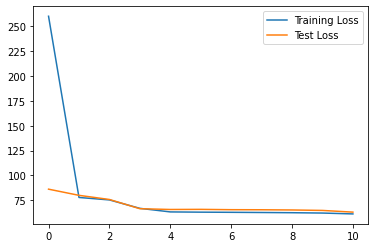

[12,     1] loss: 66.375
[12,     2] loss: 60.252
[12,     3] loss: 57.428
[12,     4] loss: 58.389
[12,     5] loss: 62.173
[12,     6] loss: 58.157
[12,     7] loss: 57.111
[12,     8] loss: 56.207
[12,     9] loss: 57.495
[12,    10] loss: 53.924
[12,    11] loss: 55.880
[12,    12] loss: 57.080
[12,    13] loss: 55.438
[12,    14] loss: 59.469
[12,    15] loss: 56.227
[12,    16] loss: 55.766
[12,    17] loss: 53.663
[12,    18] loss: 59.377
[12,    19] loss: 57.443
[12,    20] loss: 59.244
[12,    21] loss: 55.318
[12,    22] loss: 55.998
[12,    23] loss: 61.621
[12,    24] loss: 59.296
[12,    25] loss: 59.308
[12,    26] loss: 62.404
[12,    27] loss: 65.868
[12,    28] loss: 62.203
[12,    29] loss: 57.621
[12,    30] loss: 57.812
[12,    31] loss: 57.805
[12,    32] loss: 54.425
[12,    33] loss: 60.698
[12,    34] loss: 55.651
[12,    35] loss: 59.779
[12,    36] loss: 57.201
[12,    37] loss: 62.807
[12,    38] loss: 60.963
[12,    39] loss: 57.187
[12,    40] loss: 53.764


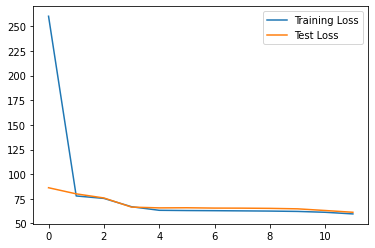

[13,     1] loss: 64.046
[13,     2] loss: 58.620
[13,     3] loss: 55.850
[13,     4] loss: 56.344
[13,     5] loss: 60.364
[13,     6] loss: 56.237
[13,     7] loss: 55.660
[13,     8] loss: 54.657
[13,     9] loss: 55.356
[13,    10] loss: 52.120
[13,    11] loss: 54.034
[13,    12] loss: 55.343
[13,    13] loss: 54.009
[13,    14] loss: 56.981
[13,    15] loss: 53.755
[13,    16] loss: 53.523
[13,    17] loss: 50.223
[13,    18] loss: 57.670
[13,    19] loss: 59.902
[13,    20] loss: 58.429
[13,    21] loss: 52.622
[13,    22] loss: 55.691
[13,    23] loss: 59.034
[13,    24] loss: 58.300
[13,    25] loss: 56.396
[13,    26] loss: 59.568
[13,    27] loss: 62.367
[13,    28] loss: 58.474
[13,    29] loss: 55.494
[13,    30] loss: 55.023
[13,    31] loss: 54.486
[13,    32] loss: 52.317
[13,    33] loss: 57.661
[13,    34] loss: 53.609
[13,    35] loss: 55.677
[13,    36] loss: 53.979
[13,    37] loss: 59.843
[13,    38] loss: 57.623
[13,    39] loss: 55.600
[13,    40] loss: 52.378


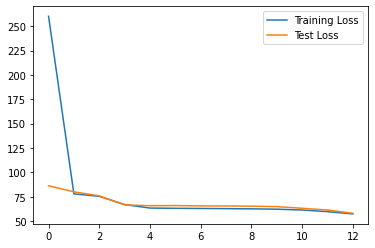

[14,     1] loss: 60.353
[14,     2] loss: 56.277
[14,     3] loss: 53.623
[14,     4] loss: 53.486
[14,     5] loss: 58.287
[14,     6] loss: 54.016
[14,     7] loss: 53.771
[14,     8] loss: 53.132
[14,     9] loss: 51.572
[14,    10] loss: 49.894
[14,    11] loss: 51.844
[14,    12] loss: 52.439
[14,    13] loss: 51.243
[14,    14] loss: 54.537
[14,    15] loss: 51.939
[14,    16] loss: 51.314
[14,    17] loss: 48.715
[14,    18] loss: 54.112
[14,    19] loss: 53.312
[14,    20] loss: 53.631
[14,    21] loss: 50.065
[14,    22] loss: 51.074
[14,    23] loss: 55.508
[14,    24] loss: 53.619
[14,    25] loss: 54.125
[14,    26] loss: 55.695
[14,    27] loss: 58.639
[14,    28] loss: 55.472
[14,    29] loss: 51.327
[14,    30] loss: 52.530
[14,    31] loss: 52.785
[14,    32] loss: 49.860
[14,    33] loss: 55.380
[14,    34] loss: 50.495
[14,    35] loss: 53.809
[14,    36] loss: 51.884
[14,    37] loss: 57.230
[14,    38] loss: 55.599
[14,    39] loss: 54.008
[14,    40] loss: 49.895


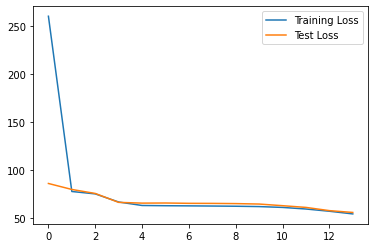

[15,     1] loss: 57.205
[15,     2] loss: 54.968
[15,     3] loss: 51.961
[15,     4] loss: 51.914
[15,     5] loss: 56.860
[15,     6] loss: 52.738
[15,     7] loss: 52.593
[15,     8] loss: 51.379
[15,     9] loss: 49.483
[15,    10] loss: 48.365
[15,    11] loss: 50.458
[15,    12] loss: 51.492
[15,    13] loss: 49.320
[15,    14] loss: 52.855
[15,    15] loss: 50.498
[15,    16] loss: 49.542
[15,    17] loss: 48.959
[15,    18] loss: 53.753
[15,    19] loss: 52.107
[15,    20] loss: 53.337
[15,    21] loss: 49.580
[15,    22] loss: 49.874
[15,    23] loss: 54.392
[15,    24] loss: 52.206
[15,    25] loss: 53.214
[15,    26] loss: 54.146
[15,    27] loss: 57.051
[15,    28] loss: 54.658
[15,    29] loss: 49.946
[15,    30] loss: 51.209
[15,    31] loss: 51.967
[15,    32] loss: 48.570
[15,    33] loss: 54.877
[15,    34] loss: 49.324
[15,    35] loss: 52.176
[15,    36] loss: 50.815
[15,    37] loss: 55.304
[15,    38] loss: 54.596
[15,    39] loss: 52.669
[15,    40] loss: 49.032


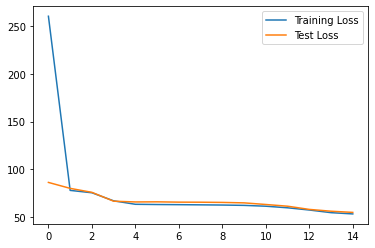

[16,     1] loss: 55.233
[16,     2] loss: 53.774
[16,     3] loss: 50.540
[16,     4] loss: 50.585
[16,     5] loss: 55.444
[16,     6] loss: 51.573
[16,     7] loss: 51.668
[16,     8] loss: 50.196
[16,     9] loss: 47.632
[16,    10] loss: 47.618
[16,    11] loss: 49.326
[16,    12] loss: 50.172
[16,    13] loss: 48.268
[16,    14] loss: 51.572
[16,    15] loss: 49.322
[16,    16] loss: 48.550
[16,    17] loss: 47.064
[16,    18] loss: 51.706
[16,    19] loss: 51.248
[16,    20] loss: 51.685
[16,    21] loss: 48.137
[16,    22] loss: 48.892
[16,    23] loss: 52.621
[16,    24] loss: 50.904
[16,    25] loss: 51.521
[16,    26] loss: 52.469
[16,    27] loss: 55.607
[16,    28] loss: 52.519
[16,    29] loss: 48.327
[16,    30] loss: 49.967
[16,    31] loss: 50.334
[16,    32] loss: 47.450
[16,    33] loss: 52.997
[16,    34] loss: 48.213
[16,    35] loss: 50.747
[16,    36] loss: 49.115
[16,    37] loss: 54.157
[16,    38] loss: 52.917
[16,    39] loss: 50.910
[16,    40] loss: 47.954


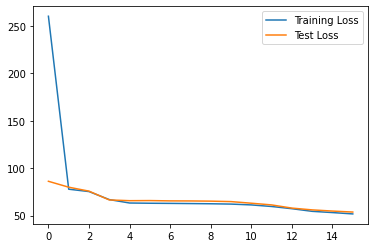

[17,     1] loss: 53.694
[17,     2] loss: 52.317
[17,     3] loss: 49.585
[17,     4] loss: 49.544
[17,     5] loss: 54.268
[17,     6] loss: 50.772
[17,     7] loss: 50.527
[17,     8] loss: 48.826
[17,     9] loss: 46.781
[17,    10] loss: 46.630
[17,    11] loss: 48.336
[17,    12] loss: 49.376
[17,    13] loss: 47.235
[17,    14] loss: 50.830
[17,    15] loss: 48.414
[17,    16] loss: 47.713
[17,    17] loss: 46.697
[17,    18] loss: 50.931
[17,    19] loss: 50.454
[17,    20] loss: 50.785
[17,    21] loss: 47.455
[17,    22] loss: 48.199
[17,    23] loss: 51.780
[17,    24] loss: 50.091
[17,    25] loss: 50.689
[17,    26] loss: 51.391
[17,    27] loss: 54.655
[17,    28] loss: 51.553
[17,    29] loss: 47.450
[17,    30] loss: 49.045
[17,    31] loss: 49.397
[17,    32] loss: 46.747
[17,    33] loss: 52.157
[17,    34] loss: 47.355
[17,    35] loss: 50.124
[17,    36] loss: 48.143
[17,    37] loss: 53.275
[17,    38] loss: 52.081
[17,    39] loss: 49.871
[17,    40] loss: 47.316


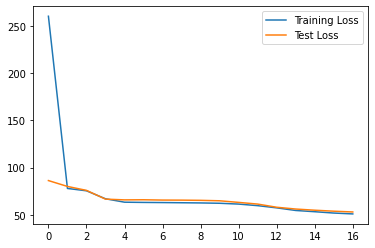

[18,     1] loss: 52.581
[18,     2] loss: 51.284
[18,     3] loss: 48.883
[18,     4] loss: 48.731
[18,     5] loss: 53.481
[18,     6] loss: 49.973
[18,     7] loss: 49.667
[18,     8] loss: 47.908
[18,     9] loss: 46.084
[18,    10] loss: 45.957
[18,    11] loss: 47.590
[18,    12] loss: 48.669
[18,    13] loss: 46.502
[18,    14] loss: 50.077
[18,    15] loss: 47.703
[18,    16] loss: 46.999
[18,    17] loss: 46.045
[18,    18] loss: 50.140
[18,    19] loss: 49.460
[18,    20] loss: 49.753
[18,    21] loss: 46.680
[18,    22] loss: 47.411
[18,    23] loss: 50.879
[18,    24] loss: 49.269
[18,    25] loss: 49.815
[18,    26] loss: 50.518
[18,    27] loss: 53.566
[18,    28] loss: 50.672
[18,    29] loss: 46.631
[18,    30] loss: 48.145
[18,    31] loss: 48.561
[18,    32] loss: 45.929
[18,    33] loss: 51.166
[18,    34] loss: 46.637
[18,    35] loss: 49.072
[18,    36] loss: 47.220
[18,    37] loss: 52.351
[18,    38] loss: 51.084
[18,    39] loss: 48.919
[18,    40] loss: 46.385


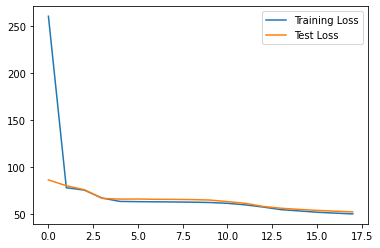

[19,     1] loss: 51.501
[19,     2] loss: 50.334
[19,     3] loss: 48.048
[19,     4] loss: 47.935
[19,     5] loss: 52.599
[19,     6] loss: 49.167
[19,     7] loss: 48.856
[19,     8] loss: 47.106
[19,     9] loss: 45.516
[19,    10] loss: 45.221
[19,    11] loss: 46.973
[19,    12] loss: 47.946
[19,    13] loss: 45.926
[19,    14] loss: 49.345
[19,    15] loss: 47.007
[19,    16] loss: 46.430
[19,    17] loss: 45.329
[19,    18] loss: 49.495
[19,    19] loss: 48.446
[19,    20] loss: 48.803
[19,    21] loss: 45.941
[19,    22] loss: 46.696
[19,    23] loss: 49.955
[19,    24] loss: 48.453
[19,    25] loss: 48.877
[19,    26] loss: 49.690
[19,    27] loss: 52.467
[19,    28] loss: 49.880
[19,    29] loss: 45.736
[19,    30] loss: 47.327
[19,    31] loss: 47.659
[19,    32] loss: 45.064
[19,    33] loss: 50.102
[19,    34] loss: 46.076
[19,    35] loss: 47.930
[19,    36] loss: 46.279
[19,    37] loss: 51.351
[19,    38] loss: 49.996
[19,    39] loss: 48.079
[19,    40] loss: 45.405


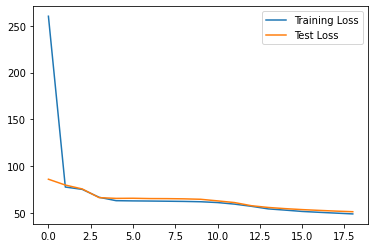

[20,     1] loss: 50.618
[20,     2] loss: 49.126
[20,     3] loss: 47.194
[20,     4] loss: 47.080
[20,     5] loss: 51.671
[20,     6] loss: 48.398
[20,     7] loss: 47.635
[20,     8] loss: 46.313
[20,     9] loss: 44.736
[20,    10] loss: 44.400
[20,    11] loss: 46.262
[20,    12] loss: 47.002
[20,    13] loss: 45.202
[20,    14] loss: 48.398
[20,    15] loss: 46.300
[20,    16] loss: 45.677
[20,    17] loss: 44.954
[20,    18] loss: 48.534
[20,    19] loss: 47.629
[20,    20] loss: 47.997
[20,    21] loss: 45.182
[20,    22] loss: 46.070
[20,    23] loss: 48.911
[20,    24] loss: 47.643
[20,    25] loss: 48.140
[20,    26] loss: 48.825
[20,    27] loss: 51.600
[20,    28] loss: 49.214
[20,    29] loss: 44.917
[20,    30] loss: 46.531
[20,    31] loss: 47.010
[20,    32] loss: 44.187
[20,    33] loss: 49.484
[20,    34] loss: 45.360
[20,    35] loss: 47.104
[20,    36] loss: 45.465
[20,    37] loss: 50.416
[20,    38] loss: 49.123
[20,    39] loss: 47.342
[20,    40] loss: 44.681


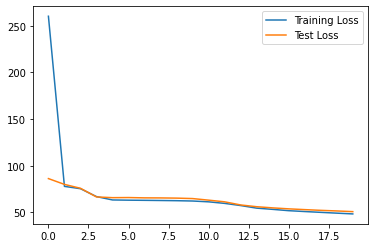

[21,     1] loss: 49.608
[21,     2] loss: 48.296
[21,     3] loss: 46.621
[21,     4] loss: 46.286
[21,     5] loss: 51.009
[21,     6] loss: 47.508
[21,     7] loss: 47.308
[21,     8] loss: 45.470
[21,     9] loss: 44.294
[21,    10] loss: 43.835
[21,    11] loss: 45.574
[21,    12] loss: 46.448
[21,    13] loss: 44.587
[21,    14] loss: 47.725
[21,    15] loss: 45.700
[21,    16] loss: 44.972
[21,    17] loss: 44.023
[21,    18] loss: 48.103
[21,    19] loss: 46.787
[21,    20] loss: 46.979
[21,    21] loss: 44.661
[21,    22] loss: 45.368
[21,    23] loss: 48.145
[21,    24] loss: 46.871
[21,    25] loss: 47.154
[21,    26] loss: 48.316
[21,    27] loss: 50.518
[21,    28] loss: 48.264
[21,    29] loss: 44.223
[21,    30] loss: 45.837
[21,    31] loss: 46.175
[21,    32] loss: 43.594
[21,    33] loss: 48.491
[21,    34] loss: 44.841
[21,    35] loss: 46.072
[21,    36] loss: 44.732
[21,    37] loss: 49.526
[21,    38] loss: 48.442
[21,    39] loss: 46.374
[21,    40] loss: 44.157


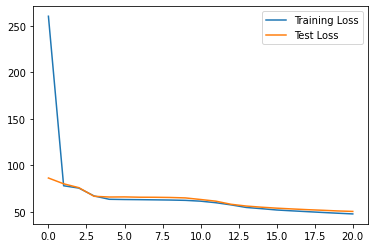

[22,     1] loss: 48.912
[22,     2] loss: 47.054
[22,     3] loss: 45.761
[22,     4] loss: 45.445
[22,     5] loss: 50.070
[22,     6] loss: 46.757
[22,     7] loss: 46.083
[22,     8] loss: 44.802
[22,     9] loss: 43.407
[22,    10] loss: 43.102
[22,    11] loss: 44.701
[22,    12] loss: 45.549
[22,    13] loss: 43.822
[22,    14] loss: 46.953
[22,    15] loss: 44.916
[22,    16] loss: 43.998
[22,    17] loss: 43.946
[22,    18] loss: 47.285
[22,    19] loss: 46.160
[22,    20] loss: 46.242
[22,    21] loss: 44.150
[22,    22] loss: 44.757
[22,    23] loss: 47.345
[22,    24] loss: 45.967
[22,    25] loss: 46.725
[22,    26] loss: 47.681
[22,    27] loss: 49.712
[22,    28] loss: 47.770
[22,    29] loss: 43.953
[22,    30] loss: 45.061
[22,    31] loss: 46.259
[22,    32] loss: 42.990
[22,    33] loss: 48.579
[22,    34] loss: 44.417
[22,    35] loss: 45.671
[22,    36] loss: 44.294
[22,    37] loss: 48.903
[22,    38] loss: 47.734
[22,    39] loss: 46.362
[22,    40] loss: 43.422


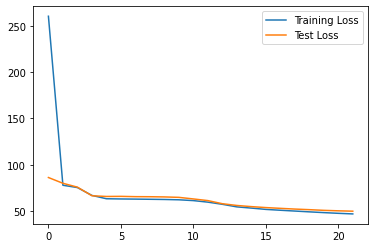

[23,     1] loss: 48.312
[23,     2] loss: 46.843
[23,     3] loss: 45.270
[23,     4] loss: 45.038
[23,     5] loss: 49.649
[23,     6] loss: 46.551
[23,     7] loss: 45.578
[23,     8] loss: 44.612
[23,     9] loss: 42.951
[23,    10] loss: 42.749
[23,    11] loss: 44.245
[23,    12] loss: 44.922
[23,    13] loss: 43.478
[23,    14] loss: 46.259
[23,    15] loss: 44.211
[23,    16] loss: 43.683
[23,    17] loss: 43.333
[23,    18] loss: 46.377
[23,    19] loss: 45.735
[23,    20] loss: 45.490
[23,    21] loss: 43.586
[23,    22] loss: 44.333
[23,    23] loss: 46.593
[23,    24] loss: 45.555
[23,    25] loss: 45.814
[23,    26] loss: 46.851
[23,    27] loss: 49.361
[23,    28] loss: 46.759
[23,    29] loss: 42.862
[23,    30] loss: 44.611
[23,    31] loss: 45.035
[23,    32] loss: 42.421
[23,    33] loss: 47.352
[23,    34] loss: 43.417
[23,    35] loss: 44.956
[23,    36] loss: 43.294
[23,    37] loss: 48.125
[23,    38] loss: 47.113
[23,    39] loss: 45.212
[23,    40] loss: 42.847


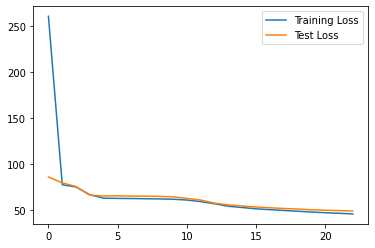

[24,     1] loss: 47.541
[24,     2] loss: 45.950
[24,     3] loss: 44.518
[24,     4] loss: 44.269
[24,     5] loss: 48.874
[24,     6] loss: 45.654
[24,     7] loss: 45.086
[24,     8] loss: 43.801
[24,     9] loss: 42.432
[24,    10] loss: 42.142
[24,    11] loss: 43.475
[24,    12] loss: 44.459
[24,    13] loss: 42.823
[24,    14] loss: 45.757
[24,    15] loss: 43.694
[24,    16] loss: 42.875
[24,    17] loss: 42.561
[24,    18] loss: 45.773
[24,    19] loss: 45.145
[24,    20] loss: 44.725
[24,    21] loss: 43.098
[24,    22] loss: 43.700
[24,    23] loss: 46.056
[24,    24] loss: 44.916
[24,    25] loss: 45.297
[24,    26] loss: 46.276
[24,    27] loss: 48.376
[24,    28] loss: 46.165
[24,    29] loss: 42.412
[24,    30] loss: 44.004
[24,    31] loss: 44.663
[24,    32] loss: 41.847
[24,    33] loss: 46.845
[24,    34] loss: 42.907
[24,    35] loss: 44.278
[24,    36] loss: 42.798
[24,    37] loss: 47.496
[24,    38] loss: 46.442
[24,    39] loss: 44.740
[24,    40] loss: 42.320


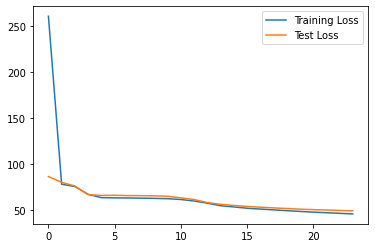

[25,     1] loss: 46.893
[25,     2] loss: 45.394
[25,     3] loss: 44.156
[25,     4] loss: 43.680
[25,     5] loss: 48.347
[25,     6] loss: 45.112
[25,     7] loss: 44.570
[25,     8] loss: 43.362
[25,     9] loss: 42.079
[25,    10] loss: 41.694
[25,    11] loss: 43.013
[25,    12] loss: 44.190
[25,    13] loss: 42.327
[25,    14] loss: 45.434
[25,    15] loss: 43.287
[25,    16] loss: 42.358
[25,    17] loss: 42.314
[25,    18] loss: 45.445
[25,    19] loss: 44.820
[25,    20] loss: 44.142
[25,    21] loss: 42.872
[25,    22] loss: 43.198
[25,    23] loss: 45.634
[25,    24] loss: 44.463
[25,    25] loss: 44.771
[25,    26] loss: 45.859
[25,    27] loss: 47.718
[25,    28] loss: 45.607
[25,    29] loss: 42.015
[25,    30] loss: 43.529
[25,    31] loss: 44.165
[25,    32] loss: 41.491
[25,    33] loss: 46.267
[25,    34] loss: 42.405
[25,    35] loss: 43.735
[25,    36] loss: 42.260
[25,    37] loss: 46.958
[25,    38] loss: 45.853
[25,    39] loss: 44.224
[25,    40] loss: 41.873


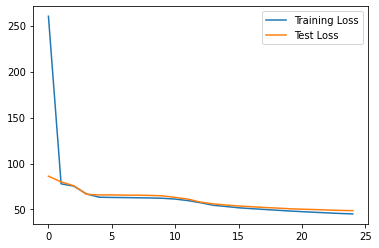

[26,     1] loss: 46.355
[26,     2] loss: 44.784
[26,     3] loss: 43.751
[26,     4] loss: 43.145
[26,     5] loss: 47.766
[26,     6] loss: 44.648
[26,     7] loss: 43.927
[26,     8] loss: 42.946
[26,     9] loss: 41.585
[26,    10] loss: 41.146
[26,    11] loss: 42.643
[26,    12] loss: 43.632
[26,    13] loss: 41.923
[26,    14] loss: 44.970
[26,    15] loss: 42.760
[26,    16] loss: 41.924
[26,    17] loss: 42.122
[26,    18] loss: 44.898
[26,    19] loss: 44.229
[26,    20] loss: 43.777
[26,    21] loss: 42.329
[26,    22] loss: 42.829
[26,    23] loss: 45.108
[26,    24] loss: 44.010
[26,    25] loss: 44.358
[26,    26] loss: 45.319
[26,    27] loss: 47.126
[26,    28] loss: 45.154
[26,    29] loss: 41.569
[26,    30] loss: 43.104
[26,    31] loss: 43.857
[26,    32] loss: 41.049
[26,    33] loss: 45.899
[26,    34] loss: 41.956
[26,    35] loss: 43.230
[26,    36] loss: 41.915
[26,    37] loss: 46.428
[26,    38] loss: 45.359
[26,    39] loss: 43.809
[26,    40] loss: 41.364


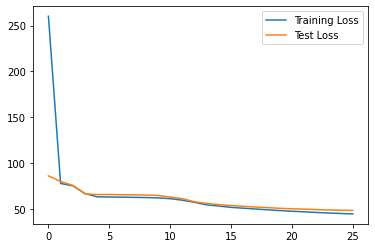

[27,     1] loss: 45.879
[27,     2] loss: 44.285
[27,     3] loss: 43.381
[27,     4] loss: 42.658
[27,     5] loss: 47.213
[27,     6] loss: 44.223
[27,     7] loss: 43.376
[27,     8] loss: 42.569
[27,     9] loss: 41.099
[27,    10] loss: 40.704
[27,    11] loss: 42.254
[27,    12] loss: 43.094
[27,    13] loss: 41.551
[27,    14] loss: 44.482
[27,    15] loss: 42.163
[27,    16] loss: 41.662
[27,    17] loss: 41.785
[27,    18] loss: 44.146
[27,    19] loss: 43.897
[27,    20] loss: 43.308
[27,    21] loss: 41.785
[27,    22] loss: 42.490
[27,    23] loss: 44.519
[27,    24] loss: 43.673
[27,    25] loss: 43.879
[27,    26] loss: 44.727
[27,    27] loss: 46.707
[27,    28] loss: 44.546
[27,    29] loss: 40.932
[27,    30] loss: 42.758
[27,    31] loss: 43.187
[27,    32] loss: 40.576
[27,    33] loss: 45.188
[27,    34] loss: 41.227
[27,    35] loss: 42.801
[27,    36] loss: 41.285
[27,    37] loss: 45.882
[27,    38] loss: 44.899
[27,    39] loss: 43.226
[27,    40] loss: 40.836


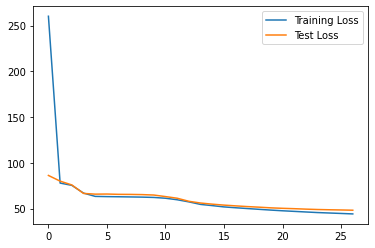

[28,     1] loss: 45.305
[28,     2] loss: 43.776
[28,     3] loss: 42.816
[28,     4] loss: 42.085
[28,     5] loss: 46.629
[28,     6] loss: 43.564
[28,     7] loss: 42.837
[28,     8] loss: 42.085
[28,     9] loss: 40.511
[28,    10] loss: 40.291
[28,    11] loss: 41.731
[28,    12] loss: 42.608
[28,    13] loss: 41.089
[28,    14] loss: 43.849
[28,    15] loss: 41.629
[28,    16] loss: 41.255
[28,    17] loss: 41.140
[28,    18] loss: 43.538
[28,    19] loss: 43.454
[28,    20] loss: 42.639
[28,    21] loss: 41.278
[28,    22] loss: 41.926
[28,    23] loss: 43.991
[28,    24] loss: 43.189
[28,    25] loss: 43.262
[28,    26] loss: 44.243
[28,    27] loss: 46.031
[28,    28] loss: 43.849
[28,    29] loss: 40.464
[28,    30] loss: 42.224
[28,    31] loss: 42.566
[28,    32] loss: 40.112
[28,    33] loss: 44.417
[28,    34] loss: 40.717
[28,    35] loss: 42.253
[28,    36] loss: 40.666
[28,    37] loss: 45.433
[28,    38] loss: 44.294
[28,    39] loss: 42.663
[28,    40] loss: 40.379


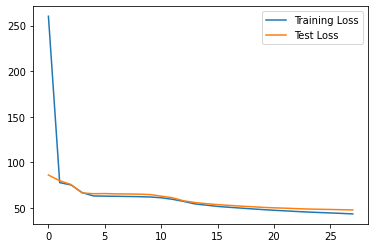

[29,     1] loss: 44.748
[29,     2] loss: 43.184
[29,     3] loss: 42.191
[29,     4] loss: 41.597
[29,     5] loss: 45.950
[29,     6] loss: 42.914
[29,     7] loss: 42.313
[29,     8] loss: 41.459
[29,     9] loss: 39.999
[29,    10] loss: 39.757
[29,    11] loss: 41.163
[29,    12] loss: 42.160
[29,    13] loss: 40.515
[29,    14] loss: 43.274
[29,    15] loss: 41.114
[29,    16] loss: 40.713
[29,    17] loss: 40.569
[29,    18] loss: 43.065
[29,    19] loss: 42.858
[29,    20] loss: 42.009
[29,    21] loss: 40.796
[29,    22] loss: 41.303
[29,    23] loss: 43.506
[29,    24] loss: 42.612
[29,    25] loss: 42.694
[29,    26] loss: 43.686
[29,    27] loss: 45.225
[29,    28] loss: 43.206
[29,    29] loss: 40.030
[29,    30] loss: 41.582
[29,    31] loss: 42.034
[29,    32] loss: 39.665
[29,    33] loss: 43.665
[29,    34] loss: 40.247
[29,    35] loss: 41.625
[29,    36] loss: 40.150
[29,    37] loss: 44.891
[29,    38] loss: 43.630
[29,    39] loss: 42.137
[29,    40] loss: 39.848


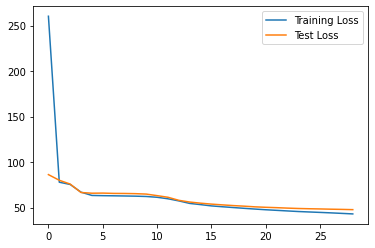

[30,     1] loss: 44.127
[30,     2] loss: 42.527
[30,     3] loss: 41.693
[30,     4] loss: 41.053
[30,     5] loss: 45.297
[30,     6] loss: 42.252
[30,     7] loss: 41.732
[30,     8] loss: 40.858
[30,     9] loss: 39.499
[30,    10] loss: 39.174
[30,    11] loss: 40.619
[30,    12] loss: 41.707
[30,    13] loss: 39.946
[30,    14] loss: 42.764
[30,    15] loss: 40.614
[30,    16] loss: 40.133
[30,    17] loss: 39.968
[30,    18] loss: 42.711
[30,    19] loss: 42.263
[30,    20] loss: 41.287
[30,    21] loss: 40.441
[30,    22] loss: 40.640
[30,    23] loss: 43.000
[30,    24] loss: 42.061
[30,    25] loss: 42.101
[30,    26] loss: 42.993
[30,    27] loss: 44.525
[30,    28] loss: 42.407
[30,    29] loss: 39.606
[30,    30] loss: 40.921
[30,    31] loss: 41.354
[30,    32] loss: 39.191
[30,    33] loss: 42.849
[30,    34] loss: 39.725
[30,    35] loss: 40.927
[30,    36] loss: 39.690
[30,    37] loss: 44.169
[30,    38] loss: 43.072
[30,    39] loss: 41.577
[30,    40] loss: 39.366


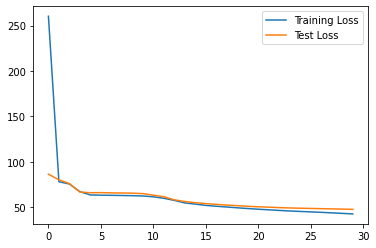

Finished Training


In [33]:
train_loss_graph = []
test_loss_graph = []

indian_loss_graph = []
western_loss_graph = []

for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    total_Loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels, fileNames = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        total_Loss += loss.item()

        if i % print_every == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / print_every))
            running_loss = 0.0
    
    print('LOSS of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
    if reduction_loss == "mean":
      total_Loss = total_Loss/i
      print('Mean of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
    
    train_loss_graph.append(total_Loss)
    correct = 0
    total = 0
    running_loss = 0.0
    total_Loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for j, data in enumerate(testloader,0):
            inputs, labels, fileNames = data
            inputs, labels = inputs.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(inputs)
            loss = criterion(outputs, inputs)
            running_loss += loss.item()
            total_Loss += loss.item()

    print('LOSS of the network on the test images: %d %%' % (total_Loss))
    if reduction_loss == "mean":
      total_Loss = total_Loss/j
      print('Mean of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
      
    
    test_loss_graph.append(total_Loss)
    visualize(train_loss_graph, test_loss_graph)

print('Finished Training')

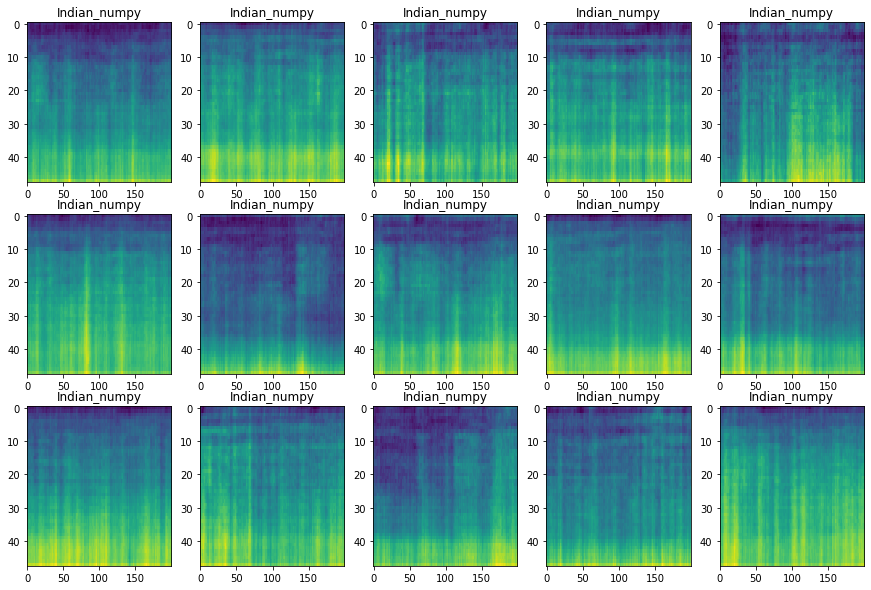

In [34]:
# get some random training images
dataiter = iter(testloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = net(image.unsqueeze(dim=0))
        ax.imshow(mel_display(output_img.detach().cpu()), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

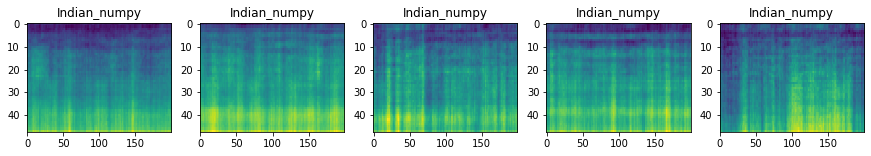

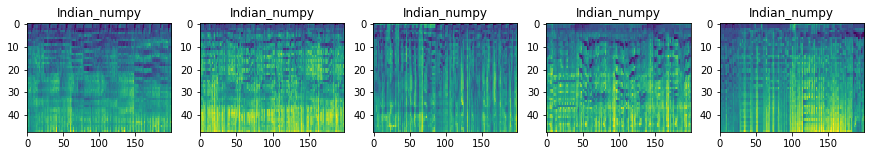

In [35]:
# get some random training images
outputs=[]
dataiter = iter(testloader)
images, labels, fileNames = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(1, 5, figsize=(15, 2))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = net(image.unsqueeze(dim=0))
        ax.imshow(mel_display(output_img.detach().cpu()), interpolation='nearest', aspect='auto') # add image
        outputs.append((mel_display(image.detach().cpu().unsqueeze(dim=0)),arthopod_types[label.item()] ))
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

fig, axis = plt.subplots(1, 5, figsize=(15, 2))
for ax , (image, label) in zip(axis.flat, outputs):
    ax.imshow(image, interpolation='nearest', aspect='auto') # add image
    ax.set(title = f"{label}") # add label
    
        

In [36]:
torch.save(net.state_dict(), os.path.join(BASE_PATH, "final_model.pt"))

Start evaluation - Test model

In [37]:
model = RecurrentAutoencoder(seq_len, input_bins, AE_encoded_dim, device=device)
model.load_state_dict(torch.load(os.path.join(BASE_PATH, "final_model.pt"), map_location=device))

<All keys matched successfully>

Combined data set recinstruction

In [ ]:
combined_dataset = MEL_Dataset(dataDF,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)
combinedloader = torch.utils.data.DataLoader(combined_dataset, batch_size=batch_size)

In [ ]:
# dataDF
# dataDF.loc[1, 'labels']
# classes
# os.path.join(BASE_PATH, "Activations_64", str(classes[label]))

In [ ]:
for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_64",  str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_128", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "reconstructions", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "originals",  str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

In [ ]:
id = 0
with torch.no_grad():
    for data in combinedloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        output_l2, output_l1 = model.encoder(inputs)
        output = model(inputs)
        output_l2 = output_l2.detach().cpu().numpy()
        output_l1 = output_l1.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        
        for  arr64, arr128, arr48, label in zip(output_l2, output_l1, output, labels):
          print(os.path.join(BASE_PATH, "Activations_64", str(classes[label]), str(id) + ".npy"))
          np.save(os.path.join(BASE_PATH, "Activations_64", str(classes[label]), str(id) + ".npy"),np.transpose(arr64, (1,0)))
          np.save(os.path.join(BASE_PATH, "Activations_128", classes[label] ,  str(id) + ".npy" ), np.transpose(arr128, (1,0)))
          np.save(os.path.join(BASE_PATH, "reconstructions", classes[label] ,  str(id) + ".npy"), np.transpose(arr48, (1,0)))
          id = id + 1

Strict data separation

In [38]:
for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_64", "test", str(class_))
  #print("removing ", dir)
  for f in os.listdir(dir):
    #print("removing ", os.path.join(dir, f))
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_128", "test", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "reconstructions", "test", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "originals", "test", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))


for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_64", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_128", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "reconstructions", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "originals", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

In [39]:
id_test = 0
with torch.no_grad():
    for data_test in testloader:
        inputs, labels, fileNames = data_test
        inputs, labels = inputs.to(device), labels.to(device)
        output_l2, output_l1 = model.encoder(inputs)
        output = model(inputs)
        output_l2 = output_l2.detach().cpu().numpy()
        output_l1 = output_l1.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        inputs = inputs.detach().cpu().numpy()
        
        for  orr48, arr64, arr128, arr48, label, fileName in zip(inputs, output_l2, output_l1, output, labels, fileNames):
          print(os.path.join(BASE_PATH, "Activations_64", "test", str(classes[label]), str(fileName)))
          np.save(os.path.join(BASE_PATH, "Activations_64", "test",str(classes[label]), str(fileName)),np.transpose(arr64, (1,0)))
          np.save(os.path.join(BASE_PATH, "Activations_128", "test",classes[label] ,  str(fileName)), np.transpose(arr128, (1,0)))
          np.save(os.path.join(BASE_PATH, "reconstructions", "test",classes[label] ,  str(fileName)), np.transpose(arr48, (1,0)))
          np.save(os.path.join(BASE_PATH, "originals", "test",classes[label] ,  str(fileName)), np.transpose(orr48, (1,0)))
          id_test = id_test + 1




/content/gdrive/My Drive/vajra/AE_HYBRID_INDIAN/Activations_64/test/Indian_numpy/indianPidiMatuli_mel_1.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_INDIAN/Activations_64/test/Indian_numpy/indianKarakudiIlavarasi_mel_1.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_INDIAN/Activations_64/test/Indian_numpy/indianHarGhoontMeinSwag_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_INDIAN/Activations_64/test/Indian_numpy/indianMereTohGirdhar_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_INDIAN/Activations_64/test/Indian_numpy/indianNainPhisalGaye_mel_1.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_INDIAN/Activations_64/test/Indian_numpy/indianRakhoRakhoRe_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_INDIAN/Activations_64/test/Indian_numpy/indianAawarwHoon_mel_1.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_INDIAN/Activations_64/test/Indian_numpy/indianMujhkoIsRaatKiTanhaiMein_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_INDIAN/Activations_64/test/Indian_numpy/indianPhirMulaaqa

In [40]:
id_train = 0
with torch.no_grad():
    for data in trainloader:
        inputs, labels, fileNames = data
        inputs, labels = inputs.to(device), labels.to(device)
        output_l2, output_l1 = model.encoder(inputs)
        output = model(inputs)
        output_l2 = output_l2.detach().cpu().numpy()
        output_l1 = output_l1.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        inputs = inputs.detach().cpu().numpy()
        
        for  orr48, arr64, arr128, arr48, label, fileName in zip(inputs, output_l2, output_l1, output, labels, fileNames):
          print(os.path.join(BASE_PATH, "Activations_64", "training", str(classes[label]), str(fileName)))
          np.save(os.path.join(BASE_PATH, "Activations_64", "training",str(classes[label]), str(fileName)),np.transpose(arr64, (1,0)))
          np.save(os.path.join(BASE_PATH, "Activations_128", "training",classes[label] ,  str(fileName)), np.transpose(arr128, (1,0)))
          np.save(os.path.join(BASE_PATH, "reconstructions", "training",classes[label] ,  str(fileName)), np.transpose(arr48, (1,0)))
          np.save(os.path.join(BASE_PATH, "originals", "training",classes[label] ,  str(fileName)), np.transpose(orr48, (1,0)))
          id_train = id_train + 1

/content/gdrive/My Drive/vajra/AE_HYBRID_INDIAN/Activations_64/training/Indian_numpy/indianPathivaayiNjan_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_INDIAN/Activations_64/training/Indian_numpy/indianKangani_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_INDIAN/Activations_64/training/Indian_numpy/indianPeelaPeela_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_INDIAN/Activations_64/training/Indian_numpy/indianMeraYaar_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_INDIAN/Activations_64/training/Indian_numpy/indianAzhiMazhai_mel_1.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_INDIAN/Activations_64/training/Indian_numpy/indianSohnea_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_INDIAN/Activations_64/training/Indian_numpy/indianZindagiTereNaal_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_INDIAN/Activations_64/training/Indian_numpy/indianSaibo_mel_0.npy
/content/gdrive/My Drive/vajra/AE_HYBRID_INDIAN/Activations_64/training/Indian_numpy/indianTeerBhangaDheu_mel